## **SIMPLE-MODEL**

In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from transformers import AutoModel,DistilBertTokenizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

In [2]:
yelp = load_dataset("yelp_review_full")
yelp

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [3]:
train_ds = yelp['train'].select(range(1000))

In [9]:
model_name = "distilbert-base-uncased"
device = 'cpu'
model = AutoModel.from_pretrained(model_name).to(device)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

In [10]:
text = "Hello , this is a simple example"

In [11]:
encoded_text = tokenizer(text,return_tensors="pt")
encoded_text

{'input_ids': tensor([[ 101, 7592, 1010, 2023, 2003, 1037, 3722, 2742,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [12]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids[0])
tokens

['[CLS]', 'hello', ',', 'this', 'is', 'a', 'simple', 'example', '[SEP]']

In [13]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] hello , this is a simple example [SEP]'

In [14]:
tokenizer.vocab_size

30522

In [15]:
max_context_length = tokenizer.model_max_length
max_context_length

512

In [16]:
def tokenize_text(batch):
    return tokenizer(batch["text"],truncation=True,padding="max_length",return_tensors="pt")

In [17]:
yelp_encodings = train_ds.map(tokenize_text,batched=True,batch_size=128)

In [18]:
yelp_encodings.set_format("torch",columns=["input_ids","attention_mask","label"])

In [19]:
def last_hidden_state(batch):
    inputs = {k: v for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        output_hidden_states = model(**inputs).last_hidden_state
    return {"hidden_state": output_hidden_states[:, 0, :].numpy()}

In [20]:
yelp_hidden_states = yelp_encodings.map(last_hidden_state, batched=True, batch_size=128)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [21]:
yelp_hidden_states

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask', 'hidden_state'],
    num_rows: 1000
})

In [22]:
import joblib
joblib.dump(yelp_hidden_states,'yelp_hidden_states.joblib')

['yelp_hidden_states.joblib']

In [23]:
cutoff = 800
X_train = np.array(yelp_hidden_states['hidden_state'][:cutoff])
y_train = np.array(yelp_hidden_states['label'][:cutoff])
X_test = np.array(yelp_hidden_states['hidden_state'][cutoff:])
y_test = np.array(yelp_hidden_states['label'][cutoff:])

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (800, 768)
y_train.shape: (800,)
X_test.shape: (200, 768)
y_test.shape: (200,)


In [24]:
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train,y_train)
dummy_model.score(X_test,y_test)

0.165

In [25]:
svm_model = SVC(kernel="linear",C=1,random_state=42)
svm_model.fit(X_train,y_train)
svm_model.score(X_test,y_test)

0.395

In [26]:
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train,y_train)
lr_model.score(X_test,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.425

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100,random_state=42)
rf_model.fit(X_train,y_train)
rf_model.score(X_test,y_test)

0.33

## **FINETUNING**

In [28]:
from transformers import AutoModelForSequenceClassification,DistilBertTokenizer,TrainingArguments,Trainer
from datasets import DatasetDict
import torch
from torch.nn.functional import cross_entropy
from sklearn.metrics import accuracy_score,confusion_matrix

In [29]:
yelp_hidden_states = joblib.load('yelp_hidden_states.joblib')

In [30]:
model_name = "distilbert-base-uncased"
device = 'cpu'
num_labels = 5
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=num_labels)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
train_ds = yelp_hidden_states.select(range(0,800))
eval_ds = yelp_hidden_states.select(range(800,1000))
print(train_ds[0]['input_ids'].shape)
print(eval_ds[0]['input_ids'].shape)
print(yelp_hidden_states[800]['input_ids'].shape)

torch.Size([512])
torch.Size([512])
torch.Size([512])


In [32]:
def change_transformers_dataset_to_right_format(dataset,label_name):
  return dataset.map(lambda examples: {'label': examples[label_name]}, remove_columns=[label_name])

In [33]:
yelp_ds_dict = DatasetDict({'train':train_ds,'test':eval_ds})

In [34]:
batch_size=8
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=500,
    disable_tqdm=False,
    push_to_hub=False,
    save_strategy='epoch',
    log_level='error',
    weight_decay=0.01,
    logging_dir="./logs"
)

In [35]:
trainer = Trainer(model=model,args=training_args,train_dataset=yelp_ds_dict['train'],eval_dataset=yelp_ds_dict['test'])
trainer.train()

Step,Training Loss


TrainOutput(global_step=200, training_loss=1.5810774230957032, metrics={'train_runtime': 91.5843, 'train_samples_per_second': 17.47, 'train_steps_per_second': 2.184, 'total_flos': 211959177216000.0, 'train_loss': 1.5810774230957032, 'epoch': 2.0})

In [36]:
trainer.evaluate()

{'eval_loss': 1.577203631401062,
 'eval_runtime': 3.5901,
 'eval_samples_per_second': 55.709,
 'eval_steps_per_second': 6.964,
 'epoch': 2.0}

In [37]:
preds = trainer.predict(yelp_ds_dict['test'])

In [38]:
preds.metrics

{'test_loss': 1.577203631401062,
 'test_runtime': 3.6762,
 'test_samples_per_second': 54.404,
 'test_steps_per_second': 6.8}

In [39]:
np.argmax(preds.predictions,axis=1)

array([0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1,
       1, 1, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 0, 2, 1, 4, 2, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 1, 1, 1, 0, 1, 2, 2, 0, 1, 0, 1, 2, 1, 1, 0, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 4, 2,
       2, 2, 0, 0, 1, 2, 1, 2, 0, 1, 4, 0, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1,
       2, 0, 0, 2, 2, 2, 0, 1, 2, 1, 0, 0, 0, 1, 0, 1, 1, 2, 2, 4, 2, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 2, 1, 0, 2, 2, 2, 1, 1, 0, 1, 2, 1, 1, 2,
       2, 2])

In [40]:
true_classes = yelp_ds_dict['test']['label']
preds_classes = np.argmax(preds.predictions,axis=1)
cm = confusion_matrix(true_classes,preds_classes)
print(cm)

[[12  8  1  0  0]
 [14 13  6  0  0]
 [ 4 12 18  0  0]
 [ 4  9 48  0  1]
 [ 8  2 37  0  3]]


<Axes: >

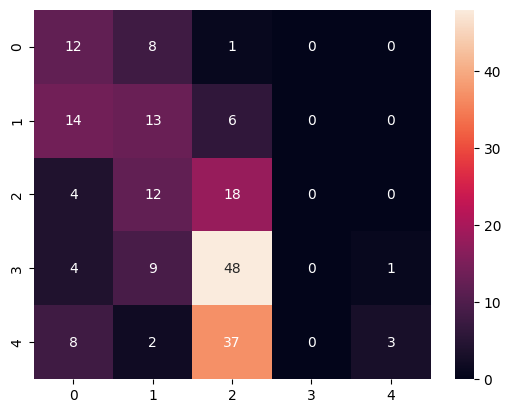

In [41]:
sns.heatmap(cm,annot=True)

In [42]:
accuracy_score(true_classes,preds_classes)

0.23

In [43]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(yelp_ds_dict['train']['label'],yelp_ds_dict['train']['label'])
dummy_clf.score(yelp_ds_dict['test']['label'],yelp_ds_dict['test']['label'])

0.165

In [44]:
model_cpu = model.to('cpu')

In [60]:
with torch.no_grad():
    outputs = model_cpu(yelp_ds_dict['test']['input_ids'],yelp_ds_dict['test']['attention_mask'])
pred_labels = torch.argmax(outputs.logits,dim=1)
loss = cross_entropy(outputs.logits,yelp_ds_dict['test']['label'],reduction='none')

In [61]:
df_individual_reviews = pd.DataFrame({
    'text': yelp_ds_dict['test']['text'],
    'label': yelp_ds_dict['test']['label'],
    'pred_label': pred_labels,
    'loss': loss}).sort_values('loss',ascending=False).reset_index(drop=True)

In [62]:
df_individual_reviews

,text,label,pred_label,loss
0,Just moved here from Baltimore and ran across ...,3,0,2.088160
1,Wondering where the Pittsburgh hipster crowd h...,3,0,1.992115
2,This place has steadily improved over the year...,3,1,1.955258
3,I am definitely the salt queen. I literally s...,3,0,1.954083
4,Visited for brunch again on a rainy winter Sun...,3,1,1.951298
...,...,...,...,...
195,"Worst tofu scramble ever. Days old, cold, hard...",0,0,1.052152
196,Don't go. I got more problems and sounds on my...,0,0,1.004673
197,The blonde woman who tuns the gym was extremel...,0,0,0.980811
198,The vet met with us for a very short amount of...,0,0,0.960112


<Axes: xlabel='label', ylabel='loss'>

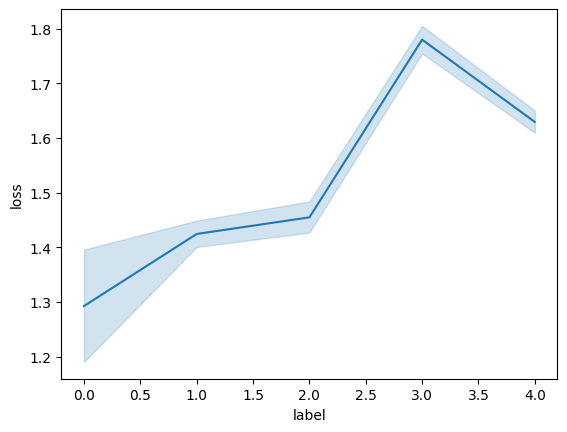

In [63]:
sns.lineplot(data=df_individual_reviews, x='label', y='loss')

In [72]:
from huggingface_hub import notebook_login
notebook_login()

In [74]:
trainer.create_model_card(model_name="Dhruv Patel/distilbert-base-uncased-yelp")
trainer.push_to_hub(commit_message="Yelp Review Classification")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/DhruvPatel1409/results/commit/aa82ce9f4be90b23ace921b777a1452a16684797', commit_message='Yelp Review Classification', commit_description='', oid='aa82ce9f4be90b23ace921b777a1452a16684797', pr_url=None, pr_revision=None, pr_num=None)

In [75]:
from transformers import pipeline

In [80]:
model_id = 'DhruvPatel1409/distilbert-base-uncased-yelp-new'
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
classifier = pipeline("sentiment-analysis",model=model_id,tokenizer=tokenizer)

config.json:   0%|          | 0.00/845 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [81]:
res = classifier("This restaurant is amazing",return_all_scores=True)[0]
df_res = pd.DataFrame(res)
df_res

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


,label,score
0,LABEL_0,0.165216
1,LABEL_1,0.211475
2,LABEL_2,0.213161
3,LABEL_3,0.190800
4,LABEL_4,0.219348


<Axes: xlabel='label', ylabel='score'>

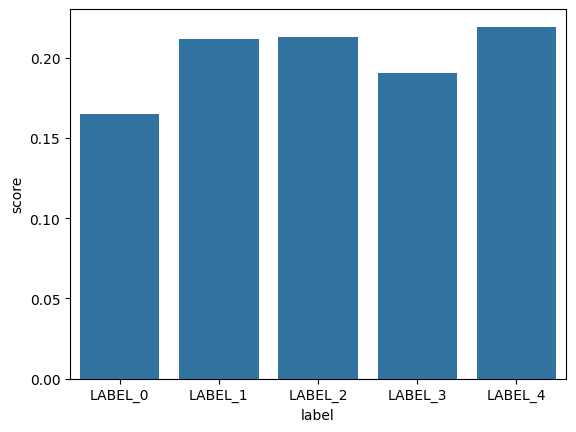

In [82]:
sns.barplot(data=df_res,x='label',y='score')